<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/master/colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [138]:
!rm -rf vgg16obj
!git clone https://github.com/soukhind2/vgg16obj


Cloning into 'vgg16obj'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 48 (delta 22), reused 37 (delta 16), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [139]:
!unzip -q /content/drive/My\ Drive/obj/data
!unzip -q /content/drive/My\ Drive/obj/test2

replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A
replace test2/scenes/bath26.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [140]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools





In [114]:
def convertimgs(path,data) :
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            im = preprocess_input(im)
            data.append(im) 
    return data


train_it = []
train_it = convertimgs('/content/data/train/faces/',train_it)
train_it = convertimgs('/content/data/train/scenes/',train_it)
train_it = convertimgs('/content/data/train/objects/',train_it)
train_it = np.array(train_it)

val_it = []
val_it = convertimgs('/content/data/val/faces',val_it)
val_it = convertimgs('/content/data/val/scenes',val_it)
val_it = convertimgs('/content/data/val/objects',val_it)
val_it = np.array(val_it)

test_it = []
test_it = convertimgs('/content/data/test/faces',test_it)
test_it = convertimgs('/content/data/test/scenes',test_it)
test_it = convertimgs('/content/data/test/objects',test_it)
test_it = np.array(test_it)

print(train_it.shape,val_it.shape,test_it.shape)


(1500, 224, 224, 3) (150, 224, 224, 3) (150, 224, 224, 3)


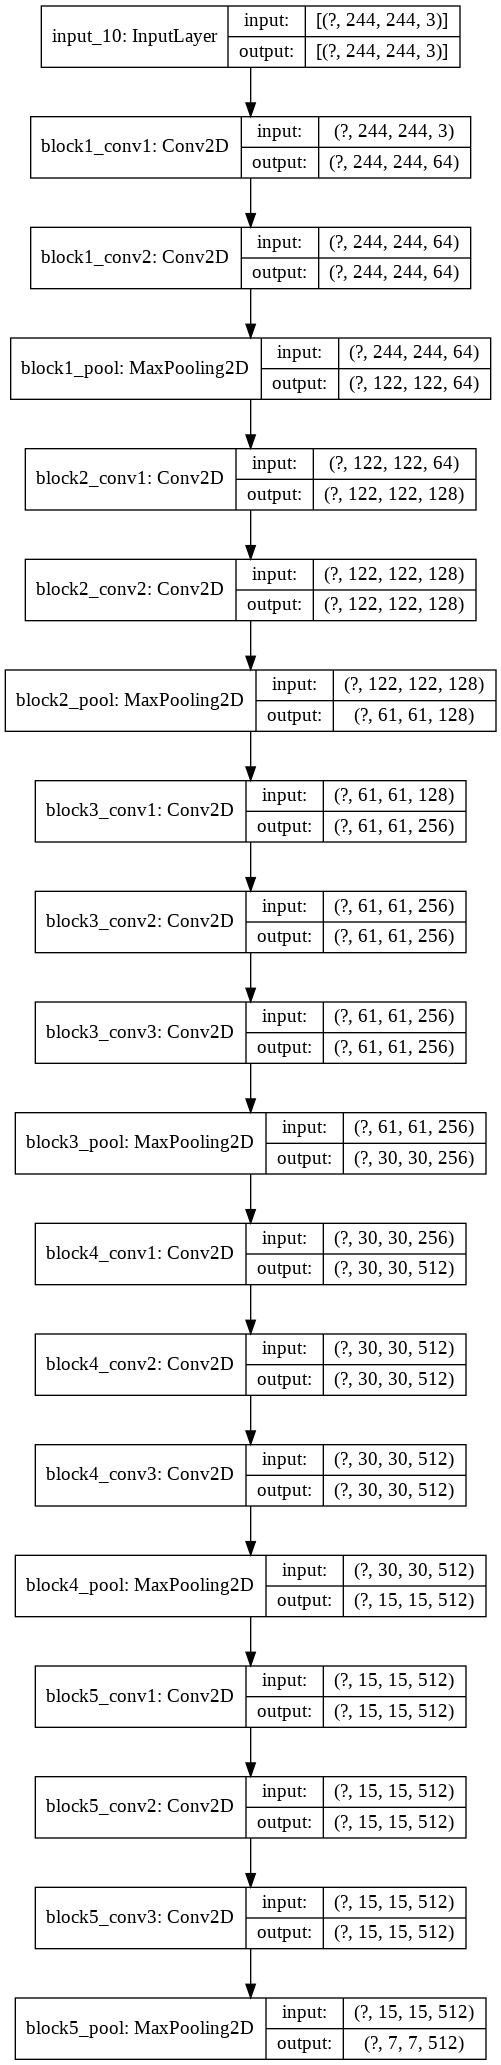

In [165]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])
plot_model(model,show_shapes=True,expand_nested=True)

In [119]:
start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')

     
#np.save('features_train' , features_train)
#np.save('features_val', features_val)
#np.save('features_test', features_test)

Train Time: 5.703347682952881
Val Time: 0.5957095623016357
Test Time: 0.602039098739624


In [120]:
epochs = 30

#train_data = np.load('features_train.npy')
train_data = features_train
train_labels = [0] * 500 + [1]*500 + [2] * 500
train_labels = to_categorical(train_labels, 3)


#val_data = np.load('features_val.npy')
val_data = features_val
val_labels = [0] * 50 + [1] * 50 + [2] * 50
val_labels = to_categorical(val_labels, 3)

#test_data = np.load('features_test.npy')
test_data = features_test
test_labels = [0] * 50 + [1] * 50 + [2] * 50
test_labels = to_categorical(test_labels, 3)


model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(4096, activation='relu')) 
##model.add(Dropout(0.5)) 
#model.add(Dense(1024, activation='relu')) 
model.add(Dense(3, activation='softmax'))

model.compile(optimizer= Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(val_data, val_labels),
          verbose = 1, callbacks = [es])
model.save_weights('top_weights',overwrite = True)


Epoch 1/30
24/24 [==============================] - 1s 31ms/step - loss: 0.3729 - accuracy: 0.9233 - val_loss: 0.0636 - val_accuracy: 0.9867
Epoch 2/30
24/24 [==============================] - 1s 26ms/step - loss: 0.0119 - accuracy: 0.9980 - val_loss: 0.0123 - val_accuracy: 0.9933
Epoch 3/30
24/24 [==============================] - 1s 25ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.0636 - val_accuracy: 0.9867
Epoch 00003: early stopping


In [121]:
out = model.evaluate(test_data,test_labels)
print(out)

pred = np.round(model.predict(test_data),0)
#print('rounded test labels',pred)

5/5 [==============================] - 0s 5ms/step - loss: 0.1234 - accuracy: 0.9867
[0.12342735379934311, 0.9866666793823242]


In [122]:
classes = ['faces','object','scene']
metric = metrics.classification_report(test_labels,pred,target_names = classes)
print(metric)


              precision    recall  f1-score   support

       faces       1.00      1.00      1.00        50
      object       0.96      1.00      0.98        50
       scene       1.00      0.96      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150
 samples avg       0.99      0.99      0.99       150



Confusion matrix, without normalization


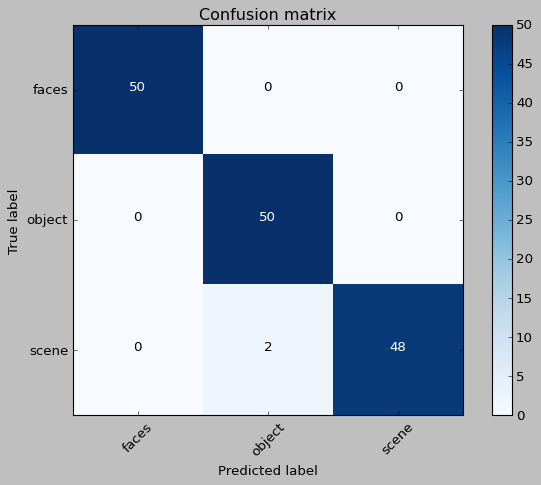

In [156]:
from vgg16obj.tools import plot_tools as pt
#pt.plot_metrics(history)

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)

pt.plot_confusion_matrix(cm,classes,normalize = False)

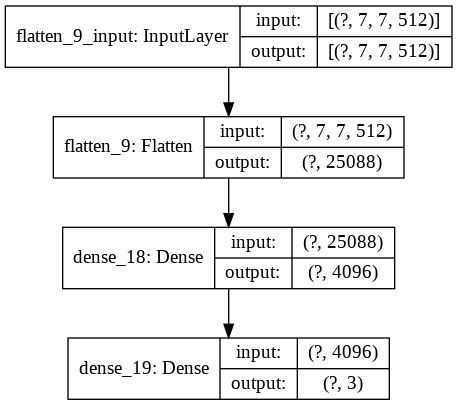

In [159]:
plot_model(model,show_shapes=True,expand_nested=True)